In [17]:
import numpy as np
import pandas as pd

from matplotlib import pylab as plt

# the following commands make plots look better
plt.rc('font', size=12)
plt.rc('xtick', direction='in') 
plt.rc('ytick', direction='in')
plt.rc('xtick.major', pad=5) 
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5) 
plt.rc('ytick.minor', pad=5)
plt.rc('lines', dotted_pattern = [2., 2.])

In [18]:
polls_df = pd.read_csv('./data/presidential_poll_averages_2020.csv')
polls_df = polls_df[polls_df['modeldate'] == '11/3/2020']
polls_df = polls_df[polls_df['candidate_name'].isin(['Joseph R. Biden Jr.','Donald Trump'])]

In [19]:
def filter_poll_data(df, end_date, states):
    """
    Filter the 538 presidential poll averages data up to a specific date and for specified states.
    
    Parameters:
    file_path (str): Path to the CSV file containing the 538 data.
    end_date (str): End date for filtering in 'MM/DD/YYYY' format.
    states (list): List of state names to include in the filtered data.
    
    Returns:
    pandas.DataFrame: Filtered DataFrame containing data up to the specified date and for the specified states.
    """    
    # Convert 'modeldate' to datetime
    df.loc[:,'modeldate'] = pd.to_datetime(df['modeldate'], format='%m/%d/%Y')
    
    # Convert end_date to datetime
    end_date = pd.to_datetime(end_date, format='%m/%d/%Y')
    
    # Filter by date
    mask_date = df['modeldate'] <= end_date
    
    # Filter by states
    mask_states = df['state'].isin(states)
    
    # Apply both filters
    filtered_df = df[mask_date & mask_states]
    
    # Sort by date and state for easier analysis
    filtered_df = filtered_df.sort_values(['modeldate', 'state'])
    
    # Reset index for clean output
    filtered_df = filtered_df.reset_index(drop=True)
    
    return filtered_df

In [20]:
# states electoral votes
states_electoral = pd.read_csv('./data/states_electoral.csv')
states      = np.array(states_electoral['Name'])

states_electoral = states_electoral.rename(columns={'Name': 'state'})

In [21]:
polls_df = filter_poll_data(polls_df,'11/3/2020',states)

In [22]:
results_df = pd.read_csv('./data/election_results_presidential.csv')
results_df = results_df[['cycle', 'candidate_name','stage','state','votes','percent']]

In [23]:
results_df = results_df[results_df['cycle'] == 2020]
results_df = results_df[results_df['stage'] == 'general']
results_df = results_df[results_df['candidate_name'].isin(['Joe Biden','Donald Trump'])]
results_df = results_df[results_df['state'].isin(states)]
results_df = results_df.dropna()

In [31]:
results_df

,cycle,candidate_name,stage,state,votes,percent
398,2020,Donald Trump,general,Kentucky,1326646.0,62.086572
401,2020,Joe Biden,general,Kentucky,772474.0,36.151515
427,2020,Donald Trump,general,Maryland,976414.0,32.150292
430,2020,Joe Biden,general,Maryland,1985023.0,65.360665
594,2020,Donald Trump,general,Colorado,1364607.0,41.897924
...,...,...,...,...,...,...
1103,2020,Joe Biden,general,West Virginia,235984.0,29.695101
1105,2020,Donald Trump,general,Washington,1584651.0,38.766978
1109,2020,Joe Biden,general,Washington,2369612.0,57.970301
1111,2020,Joe Biden,general,Wisconsin,1630866.0,49.449537


In [32]:
def remove_duplicates(df):
    # Sort the dataframe by result_pct in descending order
    df_sorted = df.sort_values('percent', ascending=False)
    
    # Keep the first occurrence (largest result_pct) for each unique combination
    df_deduplicated = df_sorted.drop_duplicates(subset=['cycle', 
                                                        'state', 
                                                        'candidate_name'], 
                                                keep='first')
    
    return df_deduplicated
final_results = remove_duplicates(results_df)

In [33]:
def combine_polls_and_results(polls_df, results_df,states_electoral):
    """
    Combine poll data with actual results and calculate bias.
    
    Parameters:
    polls_df (pandas.DataFrame): DataFrame containing poll data
    results_df (pandas.DataFrame): DataFrame containing actual election results
    
    Returns:
    pandas.DataFrame: A new DataFrame with combined data and calculated bias
    """
        # Prepare polls data
    polls = polls_df[['state', 'candidate_name', 'pct_trend_adjusted']].copy()
    polls = polls.rename(columns={'pct_trend_adjusted': 'poll_pct'})
    
    # Prepare results data and correct Biden's name
    results = results_df[['state', 'candidate_name', 'percentage']].copy()
    results['candidate_name'] = results['candidate_name'].replace('Joe Biden', 'Joseph R. Biden Jr.')
    results = results.rename(columns={'percentage': 'result_pct'})
    
    # Merge polls and results
    combined = pd.merge(polls, results, on=['state', 'candidate_name'], how='outer')
    
    # Calculate bias
    combined['bias'] = combined['result_pct'] - combined['poll_pct']
    
    # Merge with state_electoral data
    #states_electoral = states_electoral.rename(columns={'Name','state'})
    combined = pd.merge(combined, states_electoral, on='state', how='left')
    
    # Reorder columns
    combined = combined[['state', 'candidate_name', 'poll_pct', 'result_pct', 'bias', 'Electors']]
    
    # Sort by state and candidate name
    combined = combined.sort_values(['state', 'candidate_name']).reset_index(drop=True)
    
    return combined

In [35]:
final_df

,state,candidate_name,poll_pct,result_pct,bias,Electors
0,Alabama,Donald Trump,57.36126,62.031643,4.670383,9
1,Alabama,Joseph R. Biden Jr.,37.82732,36.569990,-1.257330,9
2,Alaska,Donald Trump,51.23236,52.833143,1.600783,3
3,Alaska,Joseph R. Biden Jr.,43.57005,42.771952,-0.798098,3
4,Arizona,Donald Trump,46.10181,49.055981,2.954171,11
...,...,...,...,...,...,...
97,West Virginia,Joseph R. Biden Jr.,33.51517,29.695101,-3.820069,5
98,Wisconsin,Donald Trump,43.70826,48.822437,5.114177,10
99,Wisconsin,Joseph R. Biden Jr.,52.09584,49.449537,-2.646303,10
100,Wyoming,Donald Trump,62.31048,69.936227,7.625747,3


In [36]:
def plot_dem_vs_rep_bias(df):
    """
    Plot Democratic bias vs Republican bias with electoral votes as point size.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing election data with columns
                           'state', 'candidate_name', 'bias', and 'Electors'
    """
    # Separate Democratic and Republican data
    dem_data = df[df['candidate_name'] == 'Joseph R. Biden Jr.'].set_index('state')
    rep_data = df[df['candidate_name'] == 'Donald Trump'].set_index('state')

    # Calculate biases and get electors for each state
    dem_bias = dem_data['bias']
    rep_bias = rep_data['bias']
    electors = dem_data['Electors']  # Assuming Electors are the same for both candidates in each state

    # Create the plot
    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(dem_bias, rep_bias, alpha=0.5, s=5*electors, label='2020')
    
    # Add state labels to points
    for state in dem_bias.index:
        plt.annotate(state, (dem_bias[state], rep_bias[state]), 
                     xytext=(5, 5), textcoords='offset points', 
                     fontsize=8, alpha=0.7)
    
    # Add reference lines
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
    
    # Customize the plot
    plt.title('Democratic Bias vs Republican Bias by State', fontsize=14)
    plt.ylabel('rep_results - rep_polls', fontsize=12)
    plt.xlabel('dem_results - dem_polls', fontsize=12)
    plt.grid(True,ls=':')
    plt.legend()
    plt.xlim(-10,15); plt.ylim(-10,15)
    # Add a colorbar legend for electoral votes
    #plt.colorbar(scatter, label='Electoral Votes')
    
    plt.tight_layout()
    #plt.show()

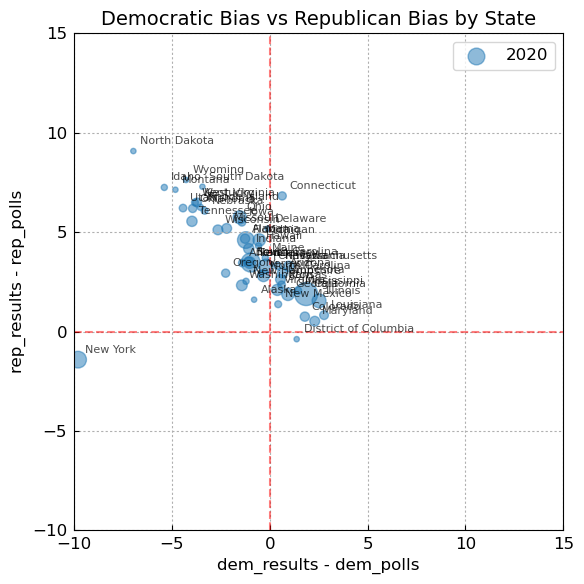

In [37]:

plot_dem_vs_rep_bias(final_df)
plt.savefig('./2020_bias.png',bbox_inches='tight',dpi=200)

In [29]:
final_df.to_csv('./data/2020_results_polls.csv',index=False)

51 51


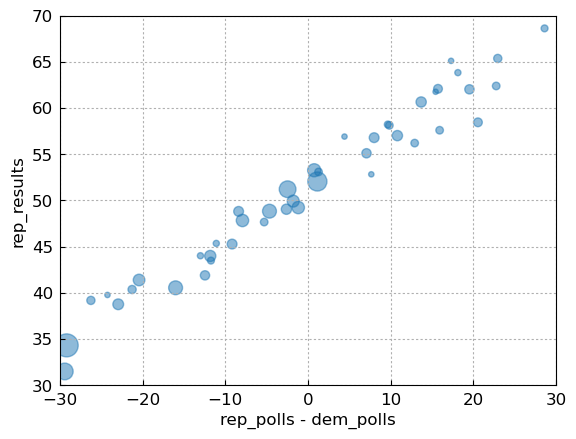

In [30]:
dem_df = final_df[final_df['candidate_name'] == 'Joseph R. Biden Jr.'].reset_index()
rep_df = final_df[final_df['candidate_name'] == 'Donald Trump'].reset_index()

print(len(dem_df['poll_pct']), len(rep_df['poll_pct']))

#rep_df['poll_pct']
plt.xlim(-30,30); plt.ylim(30,70)
plt.ylabel('rep_results')
plt.xlabel('rep_polls - dem_polls')

plt.scatter(rep_df['poll_pct']-dem_df['poll_pct'], rep_df['result_pct'], alpha=0.5,s=5*dem_df['Electors'])
plt.grid(ls=':')
#plt.show()